In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn import preprocessing
import matplotlib.pyplot as plt
import joblib

In [2]:
df = pd.read_csv('C:/Users/Administrator/Desktop/Proyecto-Aprendizaje Supervisado,Clasificación/airline_passenger_satisfaction.csv')


columns_to_drop = ['id', 'Unnamed: 0']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1, inplace=True)
df.dropna(inplace=True)

X = df.iloc[:, :-1]
y = df['satisfaction']

# Label encoders para variables categóricas
le_gender = preprocessing.LabelEncoder()
le_customer_type = preprocessing.LabelEncoder()
le_travel_type = preprocessing.LabelEncoder()
le_class = preprocessing.LabelEncoder()

# Transformación de variables categóricas  
X['Gender'] = le_gender.fit_transform(X['Gender'])
X['Customer Type'] = le_customer_type.fit_transform(X['Customer Type'])
X['Type of Travel'] = le_travel_type.fit_transform(X['Type of Travel'])
X['Class'] = le_class.fit_transform(X['Class'])

# Normalizamos el dataset de training
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

# Instancia del Clasificador Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=3)



In [3]:
# Entrenamiento del Random Forest classifier
rf.fit(X_trainset, y_trainset)

RandomForestClassifier(random_state=3)

In [4]:
# Predición del dataset de testing
predRF = rf.predict(X_testset)
# Accuracy
accuracy = metrics.accuracy_score(y_testset, predRF)
print("Accuracy del Clasificador Random Forest:", accuracy)

Accuracy del Clasificador Random Forest: 0.962096592554458


In [5]:
# Confusion Matrix
cm = confusion_matrix(y_testset, predRF)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[17188   375]
 [  803 12713]]


In [6]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_testset, predRF))


Classification Report:
                         precision    recall  f1-score   support

neutral or dissatisfied       0.96      0.98      0.97     17563
              satisfied       0.97      0.94      0.96     13516

               accuracy                           0.96     31079
              macro avg       0.96      0.96      0.96     31079
           weighted avg       0.96      0.96      0.96     31079



In [7]:
# Cross-validation score (buscamos si hay overfitting)
cv_scores = cross_val_score(rf, X, y, cv=5)
print("\nCross-validation scores:", cv_scores)
print("CV score Medio:", np.mean(cv_scores))
print("Desviación Estándar de los CV scores:", np.std(cv_scores))



Cross-validation scores: [0.96109851 0.96167769 0.95989189 0.96322216 0.96312385]
CV score Medio: 0.961802819864411
Desviación Estándar de los CV scores: 0.0012588124608484688


In [8]:
# Calcular accuracy de entrenamiento y testing para evaluar overfitting
train_accuracy = rf.score(X_trainset, y_trainset)
test_accuracy = rf.score(X_testset, y_testset)
print("\nTraining Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("Diferencia (indicación de overfitting):", train_accuracy - test_accuracy)


Training Accuracy: 1.0
Testing Accuracy: 0.962096592554458
Diferencia (indicación de overfitting): 0.03790340744554199


In [9]:
feature_names = [ 'Gender', 'Customer Type', 'Age',
                     'Type of Travel', 'Class', 'Flight Distance', 'Inflight wifi service',
                     'Departure/Arrival time convenient', 'Ease of Online booking',
                     'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
                     'Inflight entertainment', 'On-board service', 'Leg room service',
                     'Baggage handling', 'Checkin service', 'Inflight service',
                     'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

In [10]:
# Importancia de las Características
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

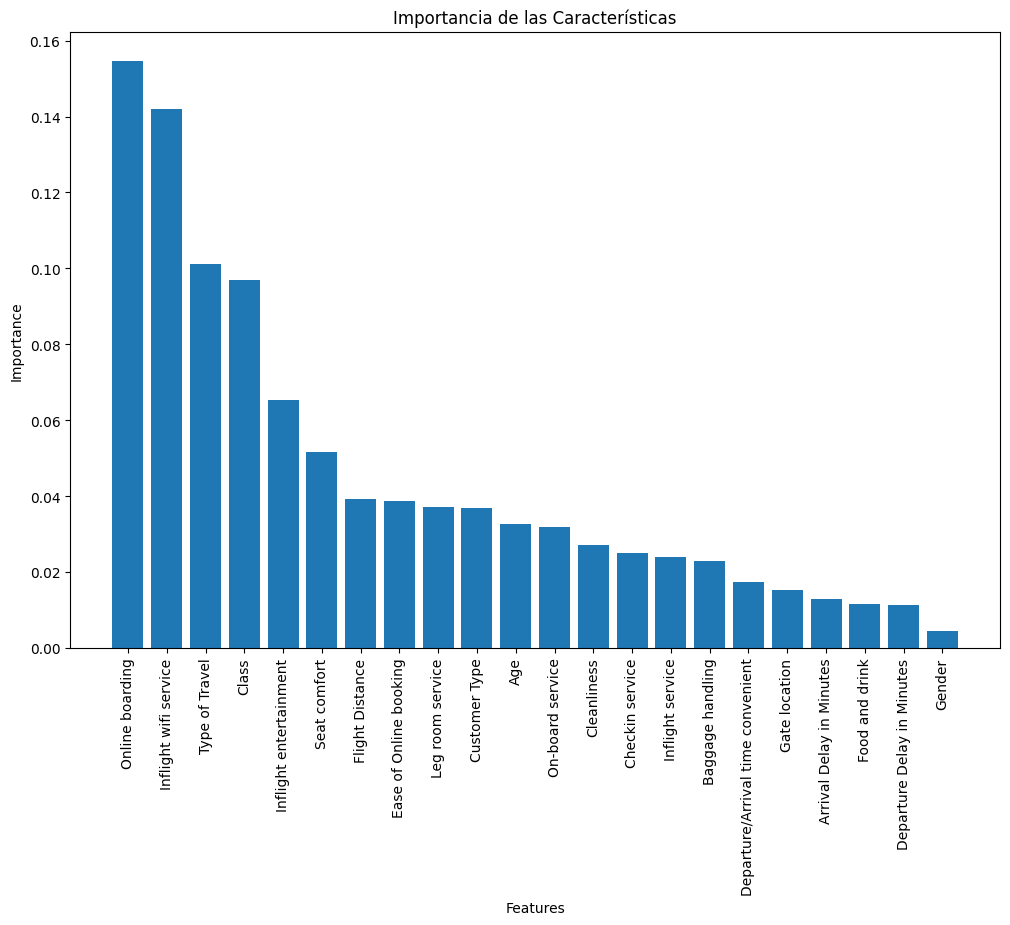

In [11]:
# Gráfica de Importancia de las Características
plt.figure(figsize=(12, 8))
plt.title("Importancia de las Características")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [12]:
# Calculamos probabilidades para la curva ROC
y_pred_proba = rf.predict_proba(X_testset)[:, 1]

In [13]:
# Cálculo de la curva ROC 
fpr, tpr, thresholds = metrics.roc_curve(y_testset, y_pred_proba, pos_label='satisfied')


In [14]:
# Calcular AUC
roc_auc = metrics.auc(fpr, tpr)

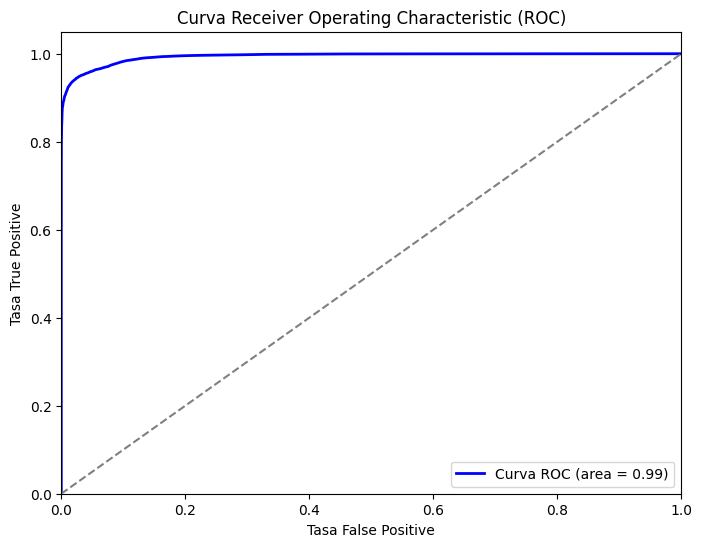

In [15]:
# Curva ROC 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa False Positive')
plt.ylabel('Tasa True Positive')
plt.title('Curva Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [16]:
# Muestra AUC score
print("AUC Score:", roc_auc)

AUC Score: 0.9938260797467005


In [17]:
# Guardamos el modelo
joblib.dump(rf, 'models/random_forest_model.joblib')


['models/random_forest_model.joblib']

In [18]:
# Definir el rango de hiperparámetros a probar en GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [19]:
# Configurar GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid,
    cv=3,  # Validación cruzada con 3 folds
    verbose=2,
    n_jobs=-1,  # Usar todos los núcleos del CPU disponibles
)

In [20]:
# Ajustar el modelo utilizando GridSearchCV
grid_search.fit(X_trainset, y_trainset)



Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


In [ ]:
# Imprimir los mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores parámetros encontrados:", best_params)



In [ ]:
# Evaluar el modelo con los mejores hiperparámetros
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_testset)



In [ ]:
# Calcular e imprimir métricas de rendimiento

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


accuracy = accuracy_score(y_testset, y_pred)
conf_matrix = confusion_matrix(y_testset, y_pred)
class_report = classification_report(y_testset, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)



In [ ]:
# Guardar el informe en un archivo de texto
with open('grid_search_report.txt', 'w') as f:
    f.write(f"Mejores parámetros encontrados: {best_params}\n\n")
    f.write(f"Accuracy: {accuracy:.4f}\n\n")
    f.write("Confusion Matrix:\n")
    f.write(np.array2string(conf_matrix))
    f.write("\n\nClassification Report:\n")
    f.write(class_report)

print("Informe guardado en grid_search_report.txt")